This short notebook is to visualize the full aggregate attention matrix created by the [T3-vis](https://arxiv.org/abs/2108.13587) aggregate attention feature. The aggregate attention function can also be found [here](https://colab.research.google.com/drive/1QaArRBpiPUWB-xqhdHQF0RuYpOmElf0x).

The aggregate attention is a list of 144 (num_layers x num_heads) lists of attentions with size (4 x seq_len x seq_len).The reason it is 4 times the size of a regular attention matrix, which is of shape (seq_len x seq_len), is because for every value in the attention matrix, we have 4 colour values (red, blue, green, alpha).

This notebook will take that list of 144 attention matrices and visualize one or all of the items in the list by creating 2D heatmaps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Dependences

In [ ]:
import os
print(os.getcwd())
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

/content


### Visualize Attention

Import your aggregate_attn.pt file into google drive/local folder and load it using the following command

In [ ]:
test = torch.load("/content/drive/MyDrive/cogs402longformer/t3-visapplication/resources/papers/pretrained/aggregate_attn.pt")

In [ ]:
print(len(test))

144


In [ ]:
print(len(test[1]['attn']))

16777216


To visualize the attention, we use matplotlib to plot out the attention matrix. First, we get the attention matrix from the above list from a range of [0 ... head x layer-1]. Note that we have to use the `attn` key to grab the matrix. Then we reshape the matrix from a 4 x seq_len x seq_len list to an array of shape (seq_len, seq_len, 4). 


Then, with matplotlib's [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function, it plots a 2-D heatmap of shape (seq_len, seq_len). The darker the part of the image looks on the heatmap, the higher the amount of attention between the tokens.

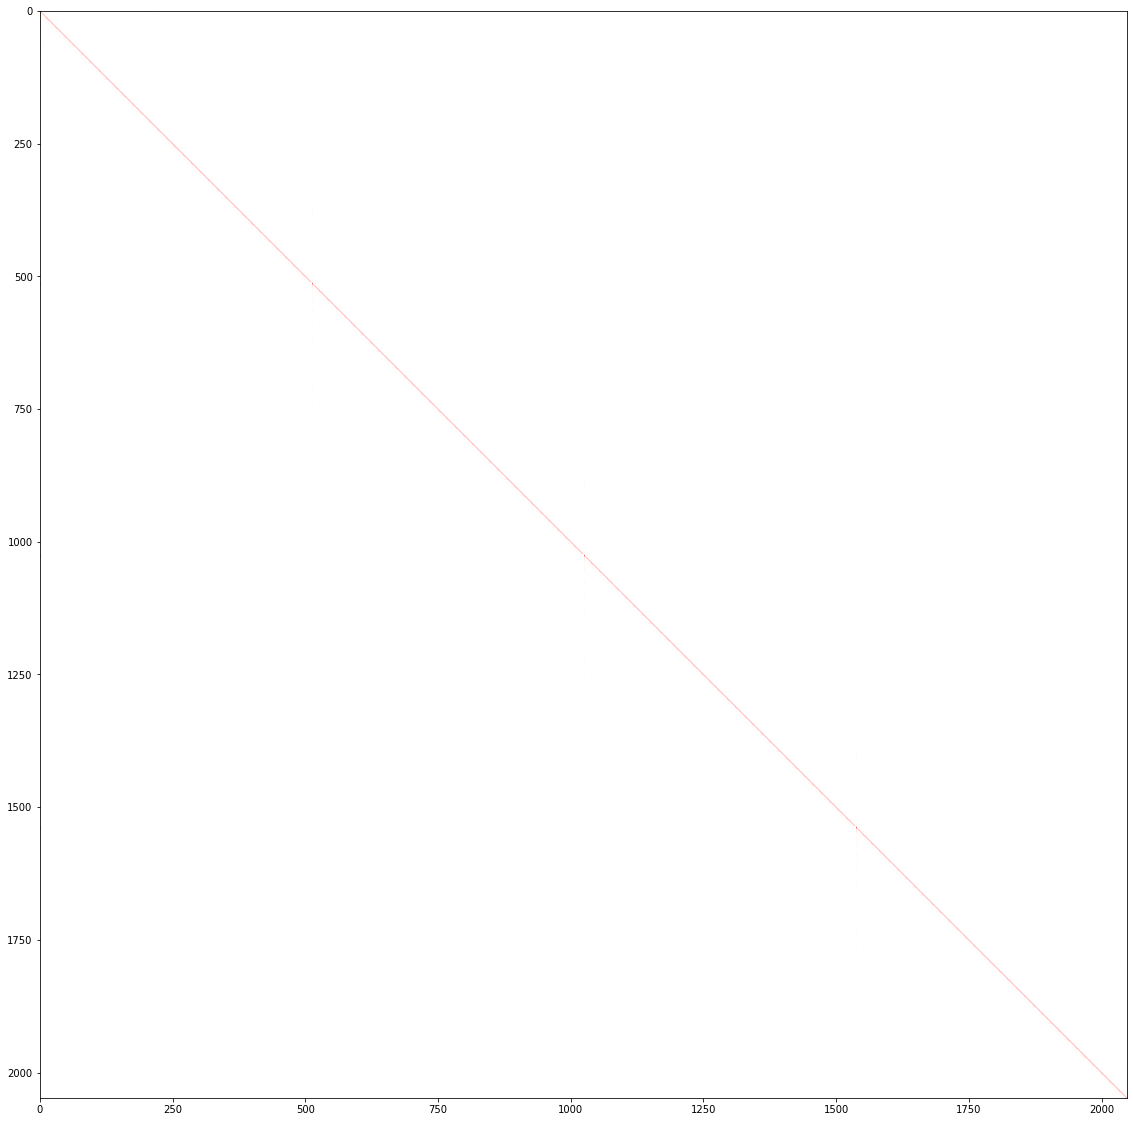

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
c = ax.imshow(np.array(test[0]['attn']).reshape((2048,2048,4)), interpolation="nearest")
plt.show()

We have functionally the same code as the previous block, but here we are plotting every attention matrix (all 144 in our code). The key difference is we have to keep track of the current row and head, so we make sure we create a new row every 12 plots. Then we can plot the matrix at the correct slot using matplotlib's subplot (axs in our code).

100%|██████████| 144/144 [03:03<00:00,  1.28s/it]


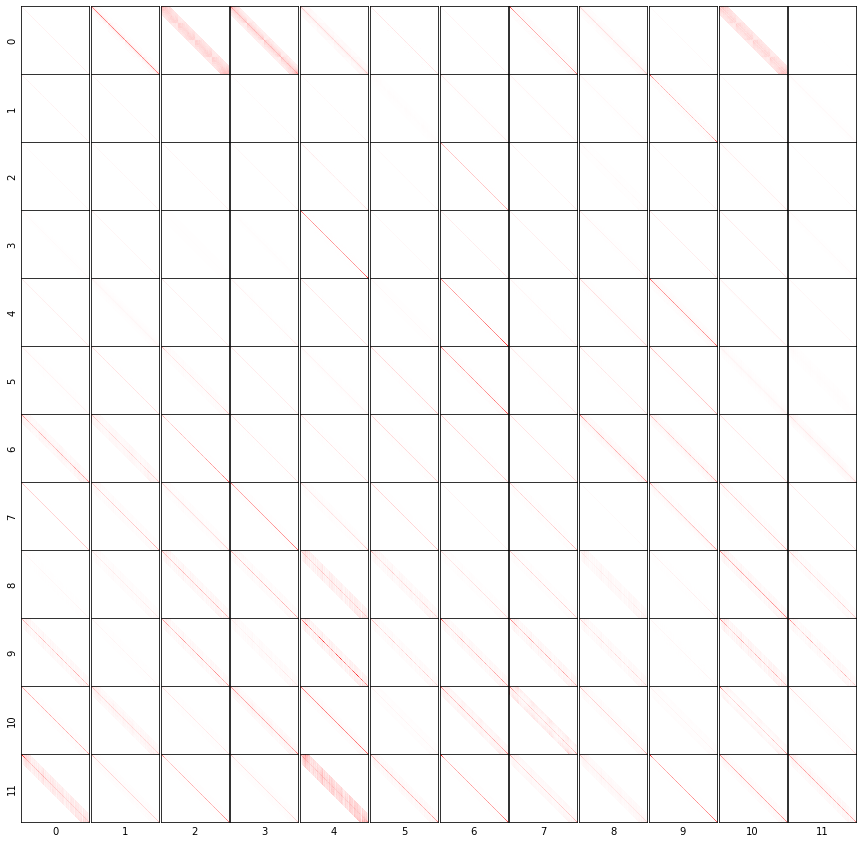

In [ ]:
import math 
from tqdm import tqdm
fig, axs = plt.subplots(12,12,figsize=(15,15))
row_num=0
for i in tqdm(range(len(test))):
    # change shape of array suited to your task
    test2 = np.array(test[0]['attn']).reshape((2048,2048,4))
    col_num = test[0]['head']
    row_num = test[0]['layer']
    c= axs[row_num, col_num].imshow(test2, interpolation="nearest")
    axs[row_num, col_num].set(xlabel = str(col_num), ylabel = str(row_num))
    axs[row_num, col_num].xaxis.set_ticks([])
    axs[row_num, col_num].yaxis.set_ticks([])
    del(test[0])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()